# SI 618 - Homework #7: Classifier - Survival on Titanic

Chenyun Tao

## Introduction

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) stated that "On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others."

According to [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview), the definitaions for the variables are
<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>Survived</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>Pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>Sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>SibSp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>Parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>Ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>Fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>Cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>Embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

In this notebook, I will try to predict "what sorts of people were more likely to survive?" based on the passenger data.

**This notebook uses some approaches from https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy and https://www.kaggle.com/startupsci/titanic-data-science-solutions.** 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

## EDA (Exploratory Data Analysis)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape,test.shape

((891, 12), (418, 11))

We can see there are 891 training data, and 418 test data.

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
640,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S


In [4]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
214,1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S
19,911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C
101,993,2,"Weisz, Mr. Leopold",male,27.0,1,0,228414,26.0000,NaN,S
292,1184,3,"Nasr, Mr. Mustafa",male,NaN,0,0,2652,7.2292,NaN,C
172,1064,3,"Dyker, Mr. Adolf Fredrik",male,23.0,1,0,347072,13.9000,NaN,S


The traing data has one more column `Survived` , which is the variable needs prediction in the test data. In the `Name` column, there exists some titles like Mr., Miss, and Master, and we might utilize this feature.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In the training data, 7 features are integer or floats, and 5 features are objects. There exist null values in `Age`, `Cabin`, and `Embarked`. In the test data, 6 features are integer or floats, and 5 features are objects. There exist null values in `Age`, `Cabin`, and `Fare`.

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here we can obtain a numerical overview of the data. For example:
* It seems that there are no unreasonable values like negative age.
* About 38% passengers in the training set survived.
* Most passengers (> 75%) did not travel with parents or children.
* Most passengers were relatively young. 75% passengers were under 38 years old.
* More than half of the passengers were in the 3rd ticket class.

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

As we have mentioned above, there exist null values in `Age`, `Cabin`, and `Embarked` in training data. In the test data, `Age`, `Cabin`, and `Fare` have null values. As there are so many null values, `Cabin` might be dropped.

In [10]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

The number of unique values in each variable is shown above. `PassengerId` and `Name` are unique for each passenger in the training data, and `Ticket` also has a lot of unique values, so it might be better to drop them or process them.

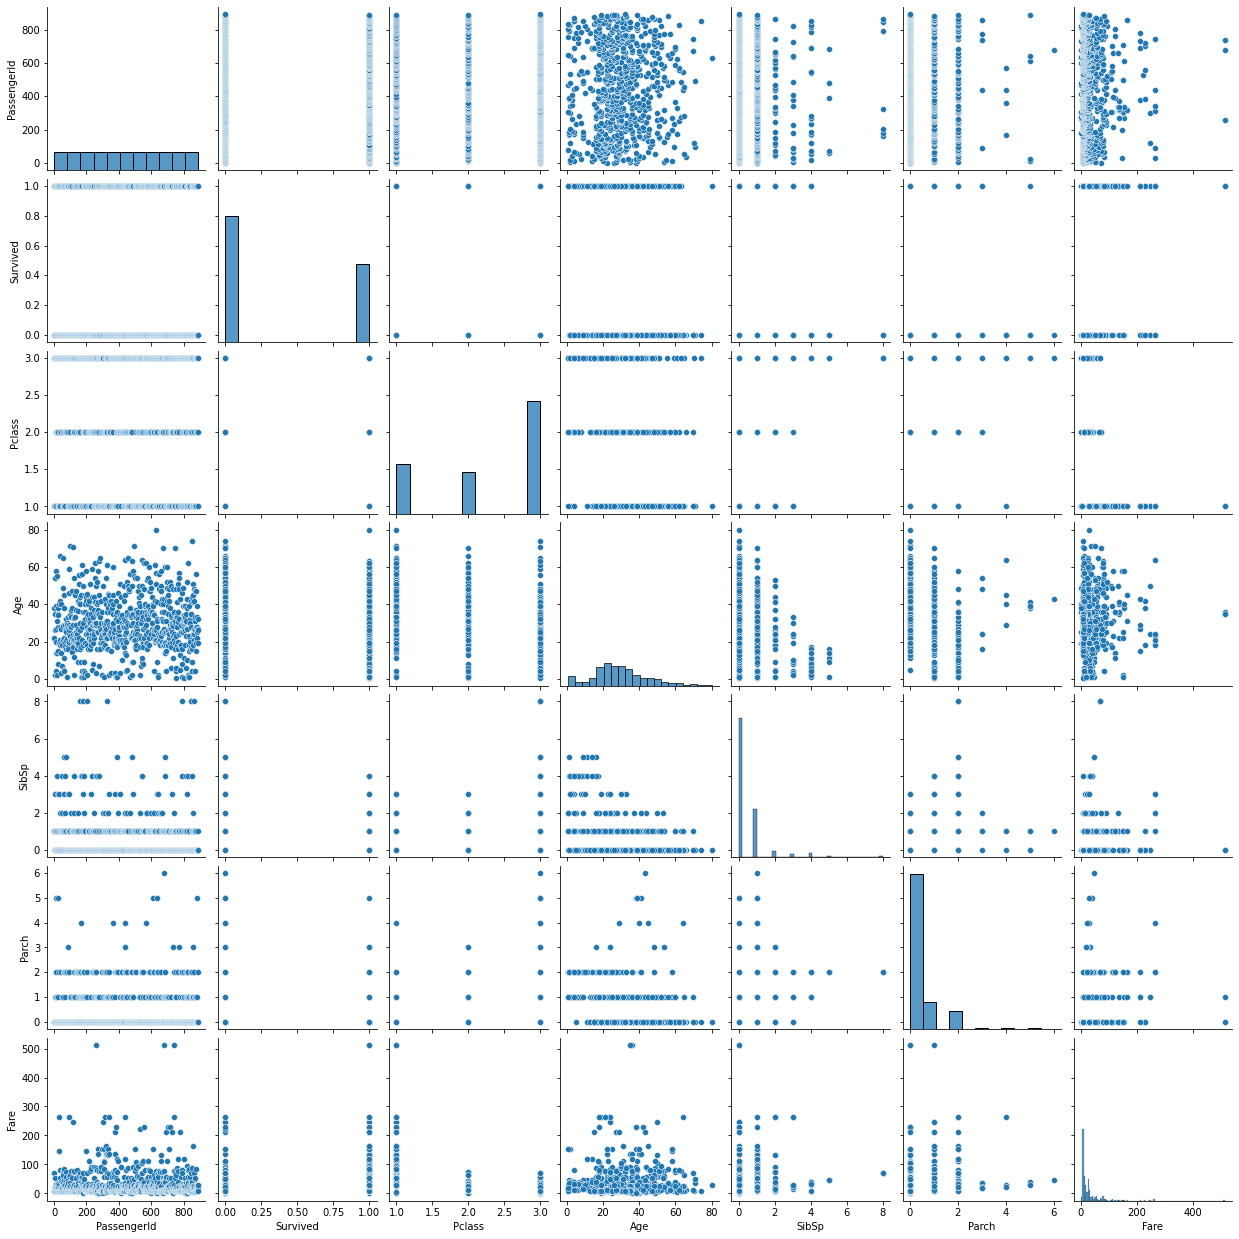

In [11]:
_ = sns.pairplot(train)

In [12]:
train_corr = train.corr()
train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


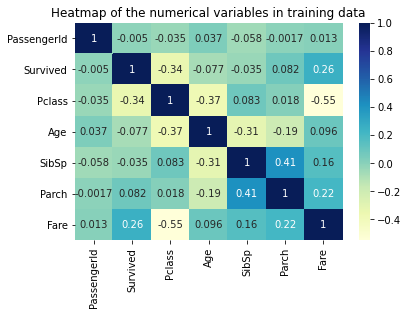

In [13]:
sns.heatmap(train_corr, cmap="YlGnBu", annot=True)
_ = plt.title("Heatmap of the numerical variables in training data")

From the pairplot and the heatmap, we can see:
* `Survived`, `Pclass`, `SibSp` and `Parch` are discrete. 
* `Pclass` and `Fare` seem to be most correlated with `Survived` in the numerical variables in the training data. 
* It might be better if we process the other variables or drop some variables, as they have relatively small correlation coefficients with `Survived` now.

In [14]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

`Survived` has two unique values: 0 and 1. 

In [15]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [16]:
train[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [17]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Besides the numerical variables, I also tried to explore the relation between `Survived` and categorical variables. `Name` and `Ticket` have so many unique values, and `Cabin` has many null values, so I did not explore them. From the above results:
* `Sex` has two unique values: female and male, `Embarked` has 3 unique values: C, Q, S, and `Pclass` has 3 unique values: 1, 2, 3.
* `Survived` is related to `Sex`, `Embarked`, and `Pclass`. Female passengers are more likely to survive. Passengers with embarked C are more likely to survive. Passengers in the first ticket class are more likely to survive.

## Preprocess the data

Based on the EDA and approaches in the reference notebooks, I decide to drop `PassengerId`, `Ticket`, `Cabin` in the data, and create new columns from extracting titles from `Name`, and combining `Parch` and `SibSp`. I first combine the training and test data to process the features, and fill the null values.

In [18]:
total = [train, test]

### Fill null values

In [19]:
train['Embarked'].fillna(train['Embarked'].dropna().mode()[0], inplace=True)

The null value in `Embarked` is filled by its mode. In addition, since only training data have null values in `Embarked`, we will only fill the training data here.

In [20]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

In [21]:
for dataset in total:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

The null value in `Fare` in the test data is filled by the median. The null values in `Age` in both training and test data are filled by the median. 

In [22]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [23]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

Double checking the data, we now have no null values except `Cabin`, which we will drop later.

### Create new features

In [24]:
for dataset in total:
    title = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    title = title.replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    title = title.replace('Mlle', 'Miss')
    title = title.replace('Ms', 'Miss')
    title = title.replace('Mme', 'Mrs')
    dataset['Title'] = title
    
train[['Title', 'Survived']].groupby('Title').mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


Here some rare titles are replaced by 'Rare', and some titles with the same meaning are replaced by a same title. It seems that our approach is reasonable, as `Title` shows correlation with `Survived`, where passengers with `Title` 'Mrs' are more likely to survive. In addition, now we can also drop the `Name` variable.

In [25]:
for dataset in total:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize', 'Survived']].groupby('FamilySize').mean()

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


In [26]:
for dataset in total:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby('IsAlone').mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


Now we have created a new variable `IsAlone` based on `SibSp` and `Parch`. The value for `IsAlone` will be 1 if the passenger is travelling alone, 0 otherwise. It seems that our approach is reasonable, as `IsAlone` shows correlation with `Survived`, where passengers not alone are more likely to survive. In addition, now we can also drop the `SibSp`, `Parch` and `FamilySize` variables.

Next, I will put the `Fare` and `Age` into groups based on the training data, so that it will be easier to do the predictions, and transfer them into ordinals manually.

In [27]:
train['FareBin'] = pd.qcut(train['Fare'], 4)
train[['FareBin', 'Survived']].groupby('FareBin').mean().sort_values(by='FareBin', ascending=True)

,Survived
FareBin,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [28]:
for dataset in total:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [29]:
train['AgeBin'] = pd.cut(train['Age'].astype(int), 5)
train[['AgeBin', 'Survived']].groupby('AgeBin').mean().sort_values(by='AgeBin', ascending=True)

,Survived
AgeBin,
"(-0.08, 16.0]",0.550000
"(16.0, 32.0]",0.344762
"(32.0, 48.0]",0.403226
"(48.0, 64.0]",0.434783
"(64.0, 80.0]",0.090909


In [30]:
for dataset in total:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    dataset['Age'] = dataset['Age'].astype(int)

It seems that our approach is reasonable, as the bins show correlation with `Survived`. Finally I created an interation variable `Age*Class`.

In [31]:
for dataset in total:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Drop useless variables

The next step is to drop the unused variables from the data.

In [32]:
train.drop(['PassengerId', 'Ticket', 'Cabin', 'Name', 'SibSp', 'Parch', 'FamilySize', 'FareBin', 'AgeBin'], axis=1, inplace = True)
test_prepared = test.drop(['PassengerId', 'Ticket', 'Cabin', 'Name', 'SibSp', 'Parch', 'FamilySize'], axis=1)

### Encode the variables

As the numerical variables are ordinals without clear orders, I could apply one hot encoding to the whole dataframe.

In [33]:
train_X = train.drop('Survived',axis=1)
train_y = train['Survived'].copy()

In [34]:
encoder = OneHotEncoder()
train_X = encoder.fit_transform(train_X)
test_prepared = encoder.transform(test_prepared)

## Train, tune and ensemble model

I use the following classifiers:
```python
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression",  LogisticRegression()),
    ("Nearest Neighbors", KNeighborsClassifier()),
    ("SVM", SVC()),
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Neural Net", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ('XGB', XGBClassifier())
```
and tune the models by cross validation. 

In [35]:
classifiers = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression",  LogisticRegression()),
    ("Nearest Neighbors", KNeighborsClassifier()), 
    ("SVM", SVC()),
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()), 
    ("Neural Net", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier())
]

seed = [42]
grid_n_estimator = [5, 10, 15, 20, 25, 30, 35, 40, 50, 100]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]

In [36]:
grid_param = [
            # GaussianNB 
            [{}],
    
            [{
            # LogisticRegression
            'fit_intercept': grid_bool, 
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'random_state': seed
             }],
            
            [{
            # KNeighborsClassifier 
            'n_neighbors': [1,2,3,4,5,6,7], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
    
            [{
            # SVC
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], 
            'gamma': grid_ratio, 
            'decision_function_shape': ['ovo', 'ovr'], 
            'probability': [True],
            'random_state': seed
             }],

            [{    
            # GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, 
            'random_state': seed
            }],
            
            [{
            # DecisionTreeClassifier
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
    
            [{
            # RandomForestClassifier
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': seed
             }],
    
            [{
            # MLPClassifer
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 1, 10],
            'random_state': seed,
            'max_iter': [1000]
            }], 
    
            [{
            # AdaBoostClassifier
            'n_estimators': grid_n_estimator, 
            'learning_rate': grid_learn, 
            'random_state': seed
            }]
        ]

In [37]:
for clf, param in zip (classifiers, grid_param):  
    best_search = GridSearchCV(estimator = clf[1], param_grid=param, cv=10)
    best_search.fit(train_X.todense(), train_y)

    best_param = best_search.best_params_
    print('The best parameter for {} is {}.'.format(clf[1].__class__.__name__, best_param))
    clf[1].set_params(**best_param) 

The best parameter for GaussianNB is {}.
The best parameter for LogisticRegression is {'fit_intercept': True, 'random_state': 42, 'solver': 'liblinear'}.
The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}.
The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.25, 'kernel': 'rbf', 'probability': True, 'random_state': 42}.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 5, 'random_state': 42}.
The best parameter for DecisionTreeClassifier is {'criterion': 'gini', 'max_depth': 4, 'random_state': 42}.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50, 'random_state': 42}.
The best parameter for MLPClassifier is {'activation': 'relu', 'alpha': 0.001, 'max_iter': 1000, 'random_state': 42}.
The best parameter for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 25, 'random_state': 42}.


I set the parameter of the models based on the best parameter found by cross validation. Then I ensemble the models using a voting classifier. There still remains one option to be determined, which is whether I should use hard voting, or soft voting in the voting classifier.

In [38]:
grid_hard = VotingClassifier(estimators=classifiers , voting='hard')
grid_hard.fit(train_X.todense(), train_y)
scores = cross_val_score(grid_hard, train_X.todense(), train_y, cv=5, n_jobs=-1)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

grid_soft = VotingClassifier(estimators=classifiers , voting='soft')
grid_soft.fit(train_X.todense(), train_y)
scores = cross_val_score(grid_soft, train_X.todense(), train_y, cv=5, n_jobs=-1)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 81.93% (+/- 6.24)
Accuracy: 81.37% (+/- 6.26)


The cross validation result shows that it might be better to use hard voting.

## Generate predictions

The final step is to generate the predictions using the hard voting classifier.

In [41]:
test['Survived'] = grid_hard.predict(test_prepared.todense())

In [42]:
result = test[['PassengerId', 'Survived']]
result.to_csv('result.csv', index=False)
result.sample(5)

,PassengerId,Survived
244,1136,0
82,974,0
248,1140,1
31,923,0
304,1196,1


The predictions receive an accuracy score of 0.763 on Kaggle.